# Modül 5 :: ML Pipeline Kurup - Değerlendirme

<a target="_blank" href="https://colab.research.google.com/github/Frightera/ML-Kursu-Youtube/blob/main/Notebooklar/ML_Modul05_SigortaVerisi_ModelFit.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>

> **Gereken paketler** (kurulu değilse):

> `pip install catboost optuna`


## Importlar

In [2]:
!pip install -q catboost optuna scikit-learn-intelex

### Temel Mantığı Nedir?

Bu kodun yaptığı işe "patching" denir. Scikit-learn, Python'da en çok kullanılan makine öğrenmesi kütüphanesidir. Ancak büyük veri setleriyle çalışırken bazı algoritmaların eğitimi uzun sürebilir.

Intel CPU ve donanımları üzerinde daha hızlı çalışacak şekilde Scikit-learn'ün popüler algoritmalarını optimize etmiştir. Bu optimize edilmiş kodları da `scikit-learn-intelex` (kısaca `sklearnex`) adında bir kütüphanede toplamıştır.

`patch_sklearn` çalıştırdığınız anda sihirli kısım gerçekleşir. Detaylarına repodan bakabilirsiniz: https://github.com/uxlfoundation/scikit-learn-intelex

In [3]:
from sklearnex import patch_sklearn

patch_sklearn()

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [ ]:
import re

import joblib
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, average_precision_score,
                             classification_report, roc_auc_score)
from sklearn.model_selection import (StratifiedKFold, cross_validate,
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

SEED = 42
np.random.seed(SEED)

## Verinin Yüklenmesi

In [7]:
df = pd.read_csv("Insurance claims data.csv")
display(df.head(3))

target_col = "claim_status"

# Gereksiz Sütunları Çıkarma: policy_id (poliçe numarası) gibi kimlik belirten sütunlar,
# her bir kayıt için genellikle benzersizdir. Bu tür sütunların modelin bir desen öğrenmesi
# veya genelleme yapması için hiçbir faydası yoktur.

df.drop(["policy_id"], inplace=True, axis=1)

y_raw = df[target_col]

if y_raw.dtype.kind in "OUSb":
    cat = pd.Categorical(y_raw)
    y = pd.Series(cat.codes, index=y_raw.index, name=target_col)
else:
    y = pd.Series(y_raw.astype(int), name=target_col)

X = df.drop(columns=[target_col])
display(X.head(3))

,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0


,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,max_power,...,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,...,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3
1,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,97.89bhp@3600rpm,...,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4
2,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,...,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3


## Kendi Transformer Objectlerimiz

Daha önceki notebook adımlarımızda, `max_power` ve `max_torque` gibi metin sütunlarından sayısal değerler çıkarmak için bir dizi `pandas` ve `re` komutu kullanmıştık.

Bu bize tek seferlik bir analiz için işe yarar. Ancak bu adımı her yeni veri geldiğinde (örneğin test verisi) tekrar tekrar, hatasız bir şekilde uygulamak ve tüm veri ön işleme adımlarını bir araya getirmek istediğimizde bu yaklaşım yetersiz kalır.

**Çözüm**: Bu mantığı yeniden kullanılabilir bir "veri işleme adımı" haline getiren özel bir Scikit-learn `Transformer` sınıfı yazmaktır.


* BaseEstimator ve TransformerMixin'den Miras Almak:

  * `BaseEstimator`, modelin parametrelerini almak (get_params) ve ayarlamak (set_params) gibi standart metodları bize verir. Bu özellikle hiperparametre optimizasyonu gibi adımlarda kullanışlı olur.
  * `TransformerMixin`, `fit` ve `transform` metodlarını birleştiren `fit_transform` metodunu otomatik olarak oluşturur.


In [8]:
class PowerTorqueRegexExtractor(BaseEstimator, TransformerMixin):

    def __init__(self, power_col="max_power", torque_col="max_torque"):

        self.power_col = power_col
        self.torque_col = torque_col

        self.bhp_pat = re.compile(r"([0-9]+\.?[0-9]*)\s*bhp", re.I)
        self.rpm_pat = re.compile(r"@\s*([0-9]+)\s*rpm", re.I)
        self.nm_pat = re.compile(r"([0-9]+\.?[0-9]*)\s*nm", re.I)

    def fit(self, X, y=None):
        """
        Sklearn' de fit metodu, transformerın veriden bir şeyler "öğrendiği" yerdir.
        Örneğin, bir StandardScaler burada eğitim verisinin ortalamasını ve standart
        sapmasını öğrenir. Ancak bizim PowerTorqueRegexExtractor'ımız stateless
        (durumsuz)'dir. Yani veriden öğrenmesi gereken hiçbir şey yoktur. Uygulayacağı
        kurallar (Regex kalıpları) sabittir. Bu nedenle fit metodu hiçbir şey yapmaz ve
        standart olarak self (yani nesnenin kendisini) döndürür.
        """
        return self

    def transform(self, X):
        s_power = X[self.power_col].astype(str)
        s_torque = X[self.torque_col].astype(str)

        X["power_bhp"] = pd.to_numeric(
            s_power.str.extract(self.bhp_pat)[0], errors="coerce"
        )
        X["power_rpm"] = pd.to_numeric(
            s_power.str.extract(self.rpm_pat)[0], errors="coerce"
        )
        X["torque_nm"] = pd.to_numeric(
            s_torque.str.extract(self.nm_pat)[0], errors="coerce"
        )
        X["torque_rpm"] = pd.to_numeric(
            s_torque.str.extract(self.rpm_pat)[0], errors="coerce"
        )

        X["bhp_per_nm"] = X["power_bhp"] / X["torque_nm"]

        # Orijinal metin sütunlarını kaldır
        # inplace=False (varsayılan) ile bir kopya döndürülür, bu da zincirleme için daha güvenlidir.
        return X.drop(columns=[self.power_col, self.torque_col])

#### Neden Önemli?

Bu sınıfı oluşturarak şunları elde ettik:

1.  **Kapsülleme (Encapsulation):** Karmaşık özellik mühendisliği mantığını tek bir, iyi tanımlanmış nesne içine hapsettik.

2.  **Tekrarlanabilirlik (Reproducibility):** Bu adımı artık bir `Pipeline`'in parçası olarak hem eğitim hem de test verisine **tamamen aynı şekilde** uygulayabiliriz. Bu, manuel hataları ve tutarsızlıkları ortadan kaldırır.

3.  **Veri Sızıntısını Önleme (Data Leakage):** `fit` ve `transform` ayrımı, tüm öğrenme işlemlerinin **sadece eğitim verisi üzerinde** yapılmasını garanti altına alır. Bizim durumumuzda bu geçerli olmasa da, `SimpleImputer` veya `StandardScaler` gibi "stateful" dönüştürücüler için bu hayati önem taşır.

4.  **Temiz Kod:** Ana kod akışımız, karmaşık `pandas` işlemleriyle dolmak yerine, `Pipeline`'e eklenen basit bir `PowerTorqueRegexExtractor()` adımıyla çok daha okunabilir hale gelir ve bunu sklearn pipeline içinde kullanabiliriz.

Pipeline'ı kaydettiğimiz zaman manuel preprocess yapmamıza gerek kalmayacak.

## Eğitim ve Test Setleri (`train_test_split`)

Bir ML modeli eğittiğimizde, nihai amacımız onun **daha önce hiç görmediği** yeni veriler üzerinde ne kadar iyi performans göstereceğini bilmektir.

Eğer modelimizi elimizdeki tüm veriyi kullanarak eğitir ve sonra performansını yine aynı veri üzerinde test edersek, bu bir öğrencinin cevaplarını ezberlediği bir sınava girmesine benzer. Öğrenci sınavda 100 alabilir, ancak bu onun konuyu gerçekten öğrendiği anlamına gelmez, sadece cevapları ezberlemiştir.

Bu "ezberleme" (overfitting) sorununu önlemek ve modelimizin gerçek dünyadaki performansını dürüstçe ölçmek için, veri setimizi iki parçaya ayırırız:

1.  **Eğitim Seti (Training Set):** Modelin, özellikler (`X`) ve hedef (`y`) arasındaki ilişkileri "öğreneceği" veri parçasıdır. Ders çalışılan kitaptır.

2.  **Test Seti (Test Set):** Model eğitildikten sonra, performansını ölçmek için kullanılacak olan, tamamen ayrılmış ve "kilitli bir kutuda" saklanmış veri parçasıdır. Modelimiz eğitim süreci boyunca bu veriyi **asla görmez**. Bu da öğrendiklerini ölçen final sınavıdır.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

## Preprocessing Pipeline

### Dataclass ile Veri Tiplerini Yönetmek

Bir ML projesi ilerledikçe, sadece verinin kendisiyle değil, aynı zamanda **veri hakkındaki veriyle (metadata)** de çalışmamız gerekir:
* Hangi sütun sayısal,
* Hangisi kategorik
* Hangisinde kaç benzersiz değer var?

Bu bilgileri düzensiz listeler veya sözlükler içinde tutmak, kodun karmaşıklaşmasına ve hatalara yol açabilir.

In [10]:
from dataclasses import dataclass


@dataclass
class ColumnInfo:
    name: str
    dtype: str
    n_unique: int

In [11]:
column_info_list = [
    ColumnInfo(name=col, dtype=df[col].dtype, n_unique=df[col].nunique())
    for col in df.columns
]

for info in column_info_list:
    print(info)

ColumnInfo(name='subscription_length', dtype=dtype('float64'), n_unique=140)
ColumnInfo(name='vehicle_age', dtype=dtype('float64'), n_unique=49)
ColumnInfo(name='customer_age', dtype=dtype('int64'), n_unique=41)
ColumnInfo(name='region_code', dtype=dtype('O'), n_unique=22)
ColumnInfo(name='region_density', dtype=dtype('int64'), n_unique=22)
ColumnInfo(name='segment', dtype=dtype('O'), n_unique=6)
ColumnInfo(name='model', dtype=dtype('O'), n_unique=11)
ColumnInfo(name='fuel_type', dtype=dtype('O'), n_unique=3)
ColumnInfo(name='max_torque', dtype=dtype('O'), n_unique=9)
ColumnInfo(name='max_power', dtype=dtype('O'), n_unique=9)
ColumnInfo(name='engine_type', dtype=dtype('O'), n_unique=11)
ColumnInfo(name='airbags', dtype=dtype('int64'), n_unique=3)
ColumnInfo(name='is_esc', dtype=dtype('O'), n_unique=2)
ColumnInfo(name='is_adjustable_steering', dtype=dtype('O'), n_unique=2)
ColumnInfo(name='is_tpms', dtype=dtype('O'), n_unique=2)
ColumnInfo(name='is_parking_sensors', dtype=dtype('O'), n_

### Column Transformer İçin Sütunları Seçmek

Bir ML modeli kurmadan önce, her bir özelliğe doğru preprocessing adımını uygulamamız gerekir. Sayısal bir sütuna metin işlemi uygulayamayız veya kategorik bir sütunun ortalamasını alamayız.

Burada DataFrame'deki her bir sütunu, kendisine uygulanacak olan işleme göre **otomatik olarak doğru gruba atamaktır**.

Bu şekilde `ColumnTransformer` gibi güçlü Sklearn araçlarını kullanarak temiz ve verimli bir ön işleme pipeline'ı oluşturmamız için temel bir adımdır.


In [14]:
numeric_cols = []
binary_cols = []
ohe_cols = []
ordinal_cols = ["ncap_rating", "airbags", "cylinder"]

# Bu iki sütunun daha önce yazdığımız özel PowerTorqueRegexExtractor sınıfı tarafından
# işleneceğini biliyoruz. Bu yüzden onları diğer tüm gruplardan ayrı tutmamız gerekir.
CUSTOM_FE_COLS = ["max_power", "max_torque"]

handled_cols = set(ordinal_cols + CUSTOM_FE_COLS)

"""
Bu for döngüsü, daha önce oluşturduğumuz column_info_list'teki her bir sütun bilgisini
(ColumnInfo nesnesini) tek tek gezer ve bir dizi kurala göre doğru listeye atar.
"""
for info in column_info_list:
    # Daha önce manuel olarak ayırdığımız sütunları bir set'e koyarız.
    # Bir set içinde bir öğeyi aramak, bir listede aramaktan çok daha hızlıdır
    if info.name in handled_cols:
        continue

    # Eğer bir sütunun sadece 2 benzersiz değeri varsa (örn: 'Yes'/'No', True/False, 0/1),
    # bu bir ikili (binary) özelliktir. Bu sütunlar genellikle basit OrdinalEncoder
    # ile 0 ve 1'e dönüştürülür.
    if info.n_unique == 2:
        binary_cols.append(info.name)

    # Eğer yukarıdaki değilse ve sütunun veri tipi int64, float64 gibi genel bir sayısal
    # tip ise bu bir numeric_col'dur. Bu sütunlara genellikle bir scaler
    # (StandardScaler gibi) uygulanır.
    elif np.issubdtype(info.dtype, np.number):
        numeric_cols.append(info.name)

    # Binary ve Numeric değilse bu aşamaya gelinir. En son kalan tipler object ise
    # Bunlara OHE uygularız. Şehir isimleri örnek verilebilir.
    elif info.dtype == "O":
        ohe_cols.append(info.name)
    else:
        print(f"Warning: Sütun '{info.name}' kategorize edilemedi.")

total_cols_in_df = len(column_info_list)
processed_cols_count = (
    len(numeric_cols)
    + len(binary_cols)
    + len(ohe_cols)
    + len(ordinal_cols)
    + len(CUSTOM_FE_COLS)
)

# Hedef değişkenimiz (claim_status) de 0 ve 1'lerden oluştuğu için binary_cols
# listesine otomatik olarak girmiştir. Ancak hedef, bir feature değildir.
# Bu yüzden onu özellik listelerimizden çıkarmamız gerekir.

binary_cols.remove(target_col)

# DataFrame'deki toplam sütun sayısı, bizim gruplara ayırdığımız toplam
# sütun sayısına eşit mi?
assert (
    total_cols_in_df == processed_cols_count
), f"Sütun sayısı tutarsız! DF: {total_cols_in_df}, pipeline: {processed_cols_count}"

print(f"Total {total_cols_in_df} sütun eşleşti")
print(f"Numeric Columns ({len(numeric_cols)}): {numeric_cols}")
print(f"Binary Columns ({len(binary_cols)}): {binary_cols}")
print(f"OHE Columns ({len(ohe_cols)}): {ohe_cols}")
print(f"Manually Defined Ordinal Columns ({len(ordinal_cols)}): {ordinal_cols}")

Total 40 sütun eşleşti
Numeric Columns (9): ['subscription_length', 'vehicle_age', 'customer_age', 'region_density', 'displacement', 'turning_radius', 'length', 'width', 'gross_weight']
Binary Columns (19): ['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type', 'transmission_type', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']
OHE Columns (6): ['region_code', 'segment', 'model', 'fuel_type', 'engine_type', 'steering_type']
Manually Defined Ordinal Columns (3): ['ncap_rating', 'airbags', 'cylinder']


Bir sonraki adım olan preprocess pipeline'ını (ColumnTransformer) kurmak için ihtiyacımız olan her şeyi artık elde etmiş olduk. Hangi sütun grubuna hangi işlemin uygulanacağını gösteren temiz ve doğrulanmış listeler.

### Ve Çok Beklenen Pipeline

EDA sürecinde birçok karar aldık:

*   Sayısal sütunlardaki eksik değerleri **medyan** ile dolduracağız.
*   Sayısal sütunları **ölçeklendireceğiz** (`StandardScaler`).
*   Kategorik sütunlardaki eksik değerleri **en sık değerle** dolduracağız.
*   İkili (binary) ve sıralı (ordinal) sütunları **sayısal etiketlere** dönüştüreceğiz (`OrdinalEncoder`).
*   Diğer kategorik sütunları **One-Hot Encoding** ile kukla değişkenlere (dummy variables) çevireceğiz.
*   Özel `PowerTorqueRegexExtractor` sınıfımızla **özellik mühendisliği** yapacağız.

Bu adımları eğitim ve test setlerine manuel olarak ayrı ayrı uygulamak hem zahmetli hem de hataya açıktır. **`Pipeline`** ve **`ColumnTransformer`**, bu adımların tamamını tek ve yeniden kullanılabilir nesnede birleştirmemizi sağlar.


In [15]:
# 1. Sayısal Sütunlar
# Eksik değerleri medyan ile doldur, sonra veriyi standartlaştır.
numeric_tf = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# 2. İkili (Binary) Sütunlar
# Eksik değerleri en sık değerle doldur, sonra kategorileri
# (örn: Yes/No) 0/1 gibi sayılara çevir.
# DÜZELTME: Test setinde eğitimde görülmeyen bir kategori gelirse hata verme,
# -1 gibi özel bir değer ata.
binary_tf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ),
    ]
)

# 3. One-Hot Encoding Uygulanacak Sütunlar
# Eksik değerleri doldur, sonra her kategoriyi yeni bir sütuna çevir.
# handle_unknown='ignore': Test setinde yeni bir kategori görürsen hata verme, o satır için tüm yeni sütunları 0 yap.
# max_categories=10: Çok fazla kategori varsa (gürültü), en sık 10 tanesini al, gerisini tek bir 'diğer' kategorisinde birleştir.
ohe_tf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "ohe",
            OneHotEncoder(
                handle_unknown="infrequent_if_exist",  # Yeni kategori görürsen 'nadir' olarak işaretle
                sparse_output=False,
                max_categories=10,  # En sık 10 kategori + 1 'nadir' kategorisi oluştur
            ),
        ),
    ]
)

# 4. Sıralı (Ordinal) Sütunlar
# İkili (binary) pipeline ile aynı mantık.
ordinal_tf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        ),
    ]
)

# 5. Sütun Yönlendirici diyebiliriz (ColumnTransformer)
# Hangi pipeline hangi sütunlara uygulanacağını belirleyen ana yönlendirici.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, numeric_cols),
        ("ord", ordinal_tf, ordinal_cols),
        ("bin", binary_tf, binary_cols),
        ("ohe", ohe_tf, ohe_cols),
    ],
    remainder="passthrough",  # İşlem görmeyen sütunları (varsa) silme, olduğu gibi bırak
)

# Tüm adımları birleştiren son pipeline
data_prep_pipeline = Pipeline(
    steps=[
        (
            "feature_engineering",
            PowerTorqueRegexExtractor(),
        ),  # Önce özel Regex dönüştürücümüz çalışır
        ("preprocessor", preprocessor),  # Sonra onun çıktısı ColumnTransformer'a gider
    ]
)

print("--- Pipeline Oluşturuldu ---")

--- Pipeline Oluşturuldu ---


## Model Fitting

Amacımız, hangi modelin (Lojistik Regresyon, Karar Ağacı, vb.) sigorta taleplerini en iyi şekilde tahmin ettiğini bulmaktır. Ancak bunu yaparken, sonuçlarımızın şans eseri veya belirli bir veri ayırımına özgü olmadığından emin olmalıyız.

#### Çapraz Doğrulama (Cross-Validation): Güvenilir Performans Ölçümü

*   **Problem:** `train_test_split` ile veriyi sadece bir kez ayırdığımızda, modelin performansı bu tek ayırıma çok bağlı olabilir. Şans eseri "kolay" bir test seti denk gelirse, modelin performansını olduğundan yüksek ölçebiliriz.
*   **Çözüm (`StratifiedKFold`):** Çapraz doğrulama, bu şans faktörünü ortadan kaldırır. `StratifiedKFold(n_splits=5)` ile eğitim verisini 5 eşit "katmana" (fold) ayırırız. Sonra sırayla:
    1.  **Deney 1:** 1. katmanı doğrulama (validation) seti olarak ayır, kalan 4 katmanla modeli eğit.
    2.  **Deney 2:** 2. katmanı doğrulama seti olarak ayır, kalan 4 katmanla modeli eğit.
    3.  ...ve bu şekilde 5 deneyin tamamı yapılır.
*   **`Stratified` Kelimesi:** `train_test_split`'te olduğu gibi, her bir katmandaki "talep" (`1`) ve "talep olmayan" (`0`) oranlarının, orijinal veri setindeki oranlarla aynı olmasını sağlar. Dengesiz veri setimiz için hayati önem taşır.

*   **Nihai Sonuç:** Modelin performansı, bu 5 deneyin sonuçlarının **ortalaması** olarak hesaplanır. Tahmin edileceği üzere tek bir deneye göre çok daha **güvenilir ve stabil** bir performans ölçütüdür.

## **NOT:** CROSS VALIDATION OVERFITTING'I ÖNLEMEZ!!!!!1!1!

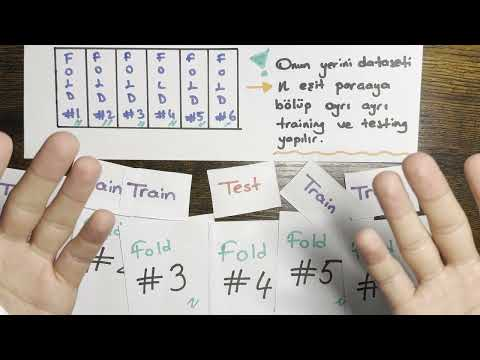

In [13]:
from IPython.display import YouTubeVideo

YouTubeVideo("dt5PIECS8B0", 1000, 650)

#### Probability Threshold Ayarlama Optimizasyonu (`TunedThresholdClassifierCV`)

*   **Problem:** Binary Classification modelleri varsayılan olarak bir olayın gerçekleşme olasılığını (0 ile 1 arasında bir skor) tahmin eder ve genellikle bu olasılık **0.5'in üzerindeyse** "1" (talep var), altındaysa "0" (talep yok) olarak karar verir.

Ancak bizim gibi dengesiz veri setlerinde, en iyi ayrımı yapan eşik değeri neredeyse hiçbir zaman 0.5 değildir.

*   **Çözüm:** `TunedThresholdClassifierCV`, bu süreci bizim için otomatize eden özel bir wrapper'dır. Her bir çapraz doğrulama deneyinde:
    1.  Modeli eğitir.
    3.  Bizim için en önemli olan metriği (bu durumda `scoring="f1"`) **maksimize eden en iyi eşik değerini** bulur ve kaydeder.

In [16]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [17]:
def get_threshold(estimator, X, y):
    # Pipeline'ın 'clf' adımına erişiyoruz, bu bizim TunedThresholdClassifierCV'miz
    # ve onun eğitildikten sonra oluşan .best_threshold_ niteliğini döndürüyoruz.
    return estimator.named_steps["clf"].best_threshold_

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

models = {
    "LogReg": TunedThresholdClassifierCV(
        estimator=LogisticRegression(max_iter=1000, solver="lbfgs", random_state=SEED),
        scoring="f1",  # Eşiği f1_macro skorunu maksimize edecek şekilde bul
        cv=cv,  # İç cross-validation için de aynı cv'yi kullanabiliriz
        random_state=SEED,
    ),
    "DecisionTree": TunedThresholdClassifierCV(
        estimator=DecisionTreeClassifier(max_depth=7, random_state=SEED),
        scoring="f1",
        cv=cv,
        random_state=SEED,
    ),
    "RandomForestClassifier": TunedThresholdClassifierCV(
        estimator=RandomForestClassifier(max_depth=7, random_state=SEED),
        scoring="f1",
        cv=cv,
        random_state=SEED,
    ),
}

pipelines = {
    name: Pipeline(steps=[("data_prep", data_prep_pipeline), ("clf", clf)])
    for name, clf in models.items()
}

Her bir model (clf) için, onu veri hazırlık pipeline'ımızla (`data_prep_pipeline`) birleştiren tam bir pipeline oluşturuyoruz:

* Artık cross_validate fonksiyonuna bu tam pipeline'ı verdiğimizde, her bir çapraz doğrulama katmanı için şunlar otomatik olarak gerçekleşir:
  * Veri hazırlık adımları (eksik değer doldurma, ölçekleme, kodlama vb.) sadece o anki eğitim katmanına uygulanır (`fit_transform`).
  * Modelimiz bu temizlenmiş eğitim katmanı üzerinde eğitilir.
  * Veri hazırlık adımları, eğitimde öğrenilen parametrelerle (veri sızıntısı olmadan) doğrulama katmanına uygulanır (transform).
  * Modelin performansı bu temizlenmiş doğrulama katmanı üzerinde ölçülür.

Bu yapı data leak'i önler (önceden scale/encoding vb. hatalardan kaynaklanan leakler).

`cross_validate`, yukarıda tanımlanan tüm süreci (CV, pipeline'ı çalıştırma, skorları hesaplama) her bir modelimiz için çalıştırır.

`scoring=scorers` parametresi sayesinde her model için sadece `F1` skorunu değil, aynı zamanda `recall`, `roc_auc` gibi diğer önemli metrikleri ve bizim özel `get_threshold` fonksiyonumuzla bulduğumuz en iyi eşik değerini de hesaplar.


In [15]:
scorers = {
    "f1": "f1",
    "recall": "recall",
    "roc_auc": "roc_auc",
    "threshold": get_threshold,
}

results = {}

for i, (name, pipe) in enumerate(pipelines.items()):
    print(f"Model: {name}")
    cv_res = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=cv,
        scoring=scorers,
        return_train_score=False,
        verbose=3,
    )
    found_thresholds = cv_res["test_threshold"]
    print(f"\t... Bulunan Eşik Değerleri: {[f'{th:.3f}' for th in found_thresholds]}")
    print(f"\t... Ortalama Eşik Değeri: {np.mean(found_thresholds):.3f}")
    results[name] = cv_res

Model: LogReg
[CV] END  f1: (test=0.150) recall: (test=0.377) roc_auc: (test=0.615) threshold: (test=0.079) total time=  26.2s
[CV] END  f1: (test=0.149) recall: (test=0.465) roc_auc: (test=0.613) threshold: (test=0.072) total time=  26.4s
[CV] END  f1: (test=0.156) recall: (test=0.455) roc_auc: (test=0.603) threshold: (test=0.075) total time=  26.6s
[CV] END  f1: (test=0.140) recall: (test=0.459) roc_auc: (test=0.594) threshold: (test=0.071) total time=  27.5s
[CV] END  f1: (test=0.144) recall: (test=0.476) roc_auc: (test=0.592) threshold: (test=0.072) total time=  26.4s
	... Bulunan Eşik Değerleri: ['0.079', '0.072', '0.075', '0.071', '0.072']
	... Ortalama Eşik Değeri: 0.074
Model: DecisionTree


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


[CV] END  f1: (test=0.170) recall: (test=0.520) roc_auc: (test=0.638) threshold: (test=0.081) total time=   4.3s
[CV] END  f1: (test=0.162) recall: (test=0.413) roc_auc: (test=0.640) threshold: (test=0.081) total time=   3.6s
[CV] END  f1: (test=0.160) recall: (test=0.367) roc_auc: (test=0.628) threshold: (test=0.091) total time=   3.5s
[CV] END  f1: (test=0.168) recall: (test=0.456) roc_auc: (test=0.639) threshold: (test=0.081) total time=   3.9s
[CV] END  f1: (test=0.164) recall: (test=0.429) roc_auc: (test=0.624) threshold: (test=0.081) total time=   4.0s
	... Bulunan Eşik Değerleri: ['0.081', '0.081', '0.091', '0.081', '0.081']
	... Ortalama Eşik Değeri: 0.083
Model: RandomForestClassifier


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.2s finished


[CV] END  f1: (test=0.168) recall: (test=0.510) roc_auc: (test=0.644) threshold: (test=0.075) total time=   7.9s
[CV] END  f1: (test=0.171) recall: (test=0.362) roc_auc: (test=0.652) threshold: (test=0.082) total time=   8.4s
[CV] END  f1: (test=0.164) recall: (test=0.452) roc_auc: (test=0.642) threshold: (test=0.077) total time=   8.6s
[CV] END  f1: (test=0.165) recall: (test=0.429) roc_auc: (test=0.647) threshold: (test=0.077) total time=   8.1s
[CV] END  f1: (test=0.159) recall: (test=0.432) roc_auc: (test=0.642) threshold: (test=0.076) total time=   8.2s
	... Bulunan Eşik Değerleri: ['0.075', '0.082', '0.077', '0.077', '0.076']
	... Ortalama Eşik Değeri: 0.077


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.2s finished


### Sınıflandırma Metrikleri - Accuracy Tek Metrik Değil

Bizim problemimizde veri setinin %93.6'sı "talep yok" (`0`), sadece %6.4'ü ise "talep var" (`1`) sınıfından oluşuyor. Bu durumda her zaman "talep yok" diyen bir model bile %93.6 doğru olabilir ama tamamen işe yaramazdır. İşte bu yüzden daha derinlemesine analiz sağlayan metriklere ihtiyacımız var.

Bu metriklerin tamamı, modelin tahminlerinin gerçek sonuçlarla karşılaştırıldığı **Karmaşıklık Matrisi (Confusion Matrix)**'nden türetilir.

#### Karmaşıklık Matrisi'nin Temel Taşları

Öncelikle, dört temel kavramı bizim problemimize uyarlayalım:

*   **True Positive (TP) - Doğru Pozitif:** Model "talep olacak" dedi ve **gerçekten de oldu**. (Harika! Riski doğru tespit ettik.)
*   **True Negative (TN) - Doğru Negatif:** Model "talep olmayacak" dedi ve **gerçekten de olmadı**. (Güzel. Güvenli müşteriyi doğru bildik.)
*   **False Positive (FP) - Yanlış Pozitif (Tip I Hata):** Model "talep olacak" dedi, ama **olmadı**. (Gereksiz alarm. Belki de bu müşteriye gereksiz yere daha yüksek bir prim teklif ettik veya bir inceleme başlattık. **Maliyet: Operasyonel verimsizlik.**)
*   **False Negative (FN) - Yanlış Negatif (Tip II Hata):** Model "talep olmayacak" dedi, ama **oldu**. (En tehlikeli hata! Gözden kaçan bir risk. Belki de sahte bir talebi veya yüksek riskli bir müşteriyi "güvenli" olarak etiketledik. **Maliyet: Finansal kayıp.**)

Şimdi bu kavramları kullanarak metriklerimizi tanımlayalım.

---

#### Precision (Kesinlik)

*   ***Sezgisel Soru: "Modelim 'talep var' dediğinde, ne kadar sıklıkla haklı çıkıyor?"***

Bu metrik pozitif tahminlerimizin kalitesini ölçer. Yüksek precision, modelin "talep var" etiketini emin olmadan bu tahmini yapmadığı anlamına gelir.

*   **Formül:**
    $$
    \text{Precision} = \frac{TP}{TP + FP}
    $$

*   **Bizim Durumumuzda Önemi:**
    Yüksek bir `Precision` skoru, **Yanlış Pozitif (FP)** maliyetini düşürmek istediğimizde önemlidir. Eğer bir talebi incelemenin operasyonel maliyeti çok yüksekse, sadece gerçekten emin olduğumuz tahminleri yapmak isteriz. Modelin her "talep olabilir" alarmının peşinden koşarak kaynakları boşa harcamasını istemeyiz.

#### Recall (Duyarlılık)

*   ***Sezgisel Soru: "Gerçekleşen tüm taleplerin yüzde kaçını yakalamayı başardım?"***

Bu metrik, pozitif vakaları tespit etme yeteneğimizi ölçer. Hiçbir talebi gözden kaçırmadığımızdan emin olmak istediğimizde en önemli metriktir.

*   **Formül:**
    $$
    \text{Recall} = \frac{TP}{TP + FN}
    $$

*   **Bizim Durumumuzda Önemi:**
    * `Recall`, risk odaklı alanlarda genellikle **en kritik metriklerden birisi olabilir**. Yüksek bir `Recall` skoru **Yanlış Negatif (FN)** maliyetini düşürmeyi hedefler.
    * Gözden kaçan her bir talep, büyük bir finansal kayıp veya kaçırılmış bir sahtekarlık vakası anlamına gelebilir. Birkaç masum müşteriyi yanlışlıkla "riskli" olarak işaretlemeyi (düşük `Precision`), gerçekten riskli olan tek bir müşteriyi bile gözden kaçırmaya (düşük `Recall`) tercih edebiliriz.

| Metrik | Odaklandığı Soru | İlgilendiği Evren | Kaçındığı Hata | Sigorta Problemindeki Anlamı |
| :--- | :--- | :--- | :--- | :--- |
| **Precision** | "Talep var" dediğimde ne kadar haklıyım? | **Sadece "talep var" diye tahmin edilenler.** | **Yanlış Pozitif (FP)**<br>(Gereksiz alarm) | Operasyonel verimliliği artırır, gereksiz incelemeleri azaltır. |
| **Recall** | Gerçekleşen tüm taleplerin ne kadarını yakaladım? | **Gerçekte "talep olan" her şey.** | **Yanlış Negatif (FN)**<br>(Gözden kaçan risk) | Finansal kaybı önler, riskleri ve sahtekarlıkları kaçırmamayı hedefler. |

#### Precision-Recall Dengesi

Bu iki metrik genellikle birbiriyle ters orantılıdır. `Recall`'ı artırmak için (yani daha fazla talebi yakalamak için) modelin karar eşiğini düşürürüz, bu da onu daha "endişeli" yapar ve daha fazla Yanlış Pozitif'e (düşük `Precision`) yol açar. Bu dengeyi kurmak, projenin iş hedeflerine bağlıdır.

#### F1 Skoru

*   ***Sezgisel Soru: "Hem Precision hem de Recall'ı dengeli bir şekilde hesaba katan tek bir skor var mı?"***

F1 Skoru (F Beta skorun genel ismidir, Beta = 1 için kısaca F1-Skor denir), `Precision` ve `Recall`'ın harmonik ortalamasıdır. Bu şekilde her iki metriğin de önemli olduğu ve aralarında bir denge aradığımız durumlar için genel bir performans ölçütüdür.

*   **Formül:**
    $$
    \text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
    $$

*   **Bizim Durumumuzda Önemi:**
    Hem Yanlış Pozitiflerin (operasyonel maliyet) hem de Yanlış Negatiflerin (finansal kayıp) maliyetli olduğu durumlarda, F1 skoru bize en dengeli modeli seçmemizde yardımcı olur. `TunedThresholdClassifierCV`'de `scoring="f1"` kullanmamızın sebebi budur: Sadece bir metriğe odaklanmak yerine, bu ikisi arasındaki dengeyi en iyi kuran karar eşiğini bulmak istiyoruz.

#### ROC AUC (Eğri Altında Kalan Alan)

*   ***Sezgisel Soru: "Modelim, belirli bir karar eşiğine bağlı olmaksızın, genel olarak pozitif ve negatif sınıfları birbirinden ne kadar iyi ayırt edebiliyor?"***

ROC AUC modelimizin **ayrım gücünü** ölçer. Birbirinden rastgele seçilen bir pozitif (`1`) ve bir negatif (`0`) örneklemden, modelin pozitif olana daha yüksek bir olasılık skoru verme ihtimalini ifade eder.

*   **Nasıl Çalışır:** Tüm olası karar eşikleri için Doğru Pozitif Oranını (Recall) Yanlış Pozitif Oranına karşı çizen bir grafiğin (ROC Eğrisi) altında kalan alanı hesaplar.
*   **Yorumlama:**
    *   **AUC = 1.0:** Müko.
    *   **AUC = 0.5:** Çöp (yazı tura atmakla aynı).
    *   **AUC = 0.0:** Çöp bile değil.

*   **Bizim Durumumuzda Önemi:**
    ROC AUC, **karar eşiğinden bağımsızdır**. Bir modelin AUC'si diğerinden daha yüksekse, bu, o modelin "talep" ve "talep yok" durumlarını temel olarak daha iyi ayırt edebildiği anlamına gelir. Sonrasında bu daha iyi olasılıkları en iyi F1 skorunu veren bir eşikle birleştirerek en iyi nihai kararları alabiliriz.

In [16]:
results

{'LogReg': {'fit_time': array([25.89715672, 26.16183329, 26.25167084, 27.14441109, 26.09967542]),
  'score_time': array([0.32594991, 0.26872969, 0.34276581, 0.33941317, 0.25527453]),
  'test_f1': array([0.1498177 , 0.1488794 , 0.15564424, 0.14019883, 0.14375788]),
  'test_recall': array([0.37666667, 0.465     , 0.455     , 0.4590985 , 0.47579299]),
  'test_roc_auc': array([0.61451529, 0.61324368, 0.60273096, 0.59422152, 0.59177975]),
  'test_threshold': array([0.07887117, 0.07249576, 0.07498278, 0.07103585, 0.07179365])},
 'DecisionTree': {'fit_time': array([3.73162794, 3.31196523, 3.21703243, 3.35382795, 3.75425792]),
  'score_time': array([0.5243299 , 0.25464201, 0.26191783, 0.53705597, 0.25704098]),
  'test_f1': array([0.16970356, 0.16230366, 0.16029144, 0.16794832, 0.16395534]),
  'test_recall': array([0.52      , 0.41333333, 0.36666667, 0.4557596 , 0.42904841]),
  'test_roc_auc': array([0.63753495, 0.64048993, 0.62757198, 0.63854211, 0.6243693 ]),
  'test_threshold': array([0.0808

## En İyi Modeli Nasıl Seçelim?

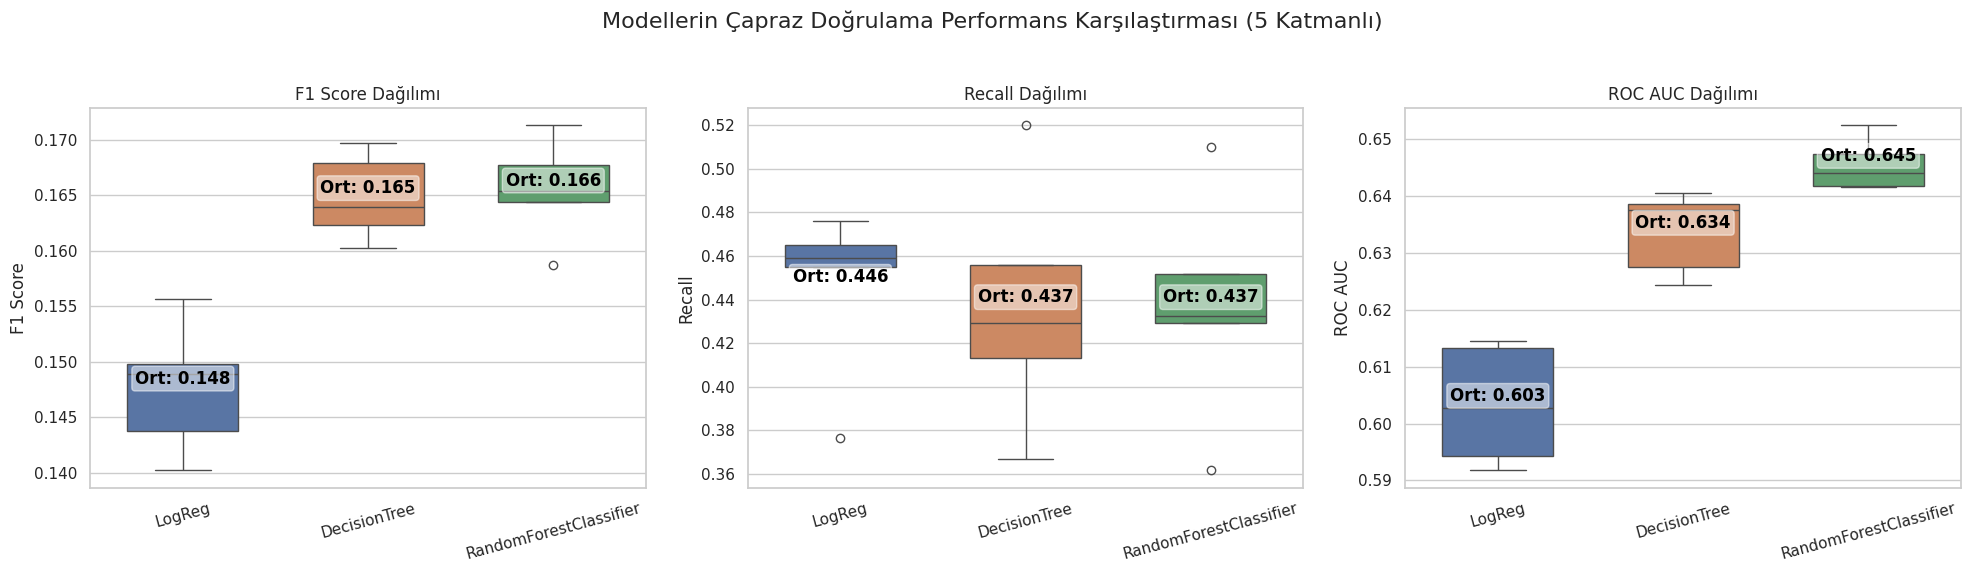

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_data = []
metrics_to_plot = {
    "F1 Score": "test_f1",
    "Recall": "test_recall",
    "ROC AUC": "test_roc_auc",
}

for model_name, model_results in results.items():
    for plot_name, internal_name in metrics_to_plot.items():
        for score in model_results[internal_name]:
            plot_data.append({"Model": model_name, "Metric": plot_name, "Score": score})

df_plot = pd.DataFrame(plot_data)

# 2. Grafiği oluşturma
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)
fig.suptitle(
    "Modellerin Çapraz Doğrulama Performans Karşılaştırması (5 Katmanlı)", fontsize=16
)

# Her bir metrik için ayrı bir subplot çiz
for i, (plot_name, internal_name) in enumerate(metrics_to_plot.items()):
    ax = axes[i]

    # O anki metrik için veriyi filtrele
    metric_df = df_plot[df_plot["Metric"] == plot_name]

    # Boxplot'u çiz
    sns.boxplot(x="Model", y="Score", data=metric_df, ax=ax, palette="deep", width=0.6)

    ax.set_title(f"{plot_name} Dağılımı")
    ax.set_xlabel("")  # Alt etiketleri temizle
    ax.set_ylabel(plot_name)
    ax.tick_params(axis="x", rotation=15)

    # 3. Her bir kutunun üzerine ortalama değeri yazdırma
    model_names = metric_df["Model"].unique()
    for j, model in enumerate(model_names):
        mean_val = results[model][internal_name].mean()
        ax.text(
            j,
            mean_val,
            f"Ort: {mean_val:.3f}",
            ha="center",
            va="bottom",
            fontweight="bold",
            color="black",
            bbox=dict(facecolor="white", alpha=0.5, boxstyle="round,pad=0.2"),
        )

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ana başlığın sıkışmasını önle
plt.show()

En iyi model nedir?

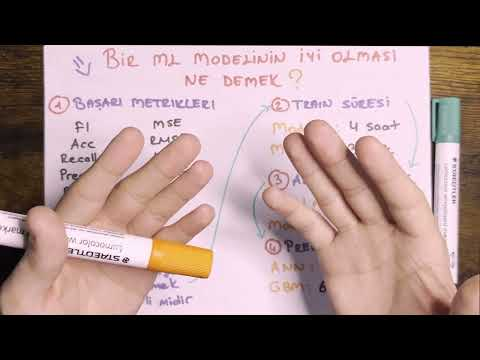

In [14]:
YouTubeVideo("Kyi_l9h4Mug", 1000, 650)

## Test Setinde Final Değerlendirme


Classification Report (Test):

              precision    recall  f1-score   support

           0     0.9424    0.8541    0.8961     10969
           1     0.0996    0.2360    0.1401       750

    accuracy                         0.8146     11719
   macro avg     0.5210    0.5451    0.5181     11719
weighted avg     0.8884    0.8146    0.8477     11719

ROC-AUC (test): 0.6363 | AP (PR-AUC): 0.0935


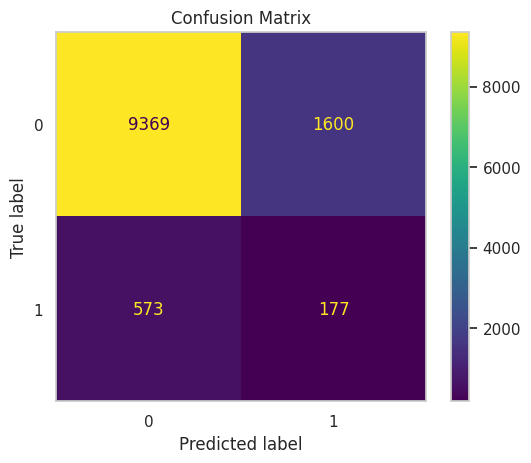

In [22]:
best_pipe = pipelines["DecisionTree"]
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)
print("\nClassification Report (Test):\n")
print(classification_report(y_test, y_pred, digits=4))

if hasattr(best_pipe.named_steps["clf"], "predict_proba"):
    y_proba = best_pipe.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    print(f"ROC-AUC (test): {roc:.4f} | AP (PR-AUC): {ap:.4f}")

ConfusionMatrixDisplay.from_estimator(best_pipe, X_test, y_test)
plt.title(f"Confusion Matrix")
plt.grid(False)
plt.show()

## Gradient Boosting HPO

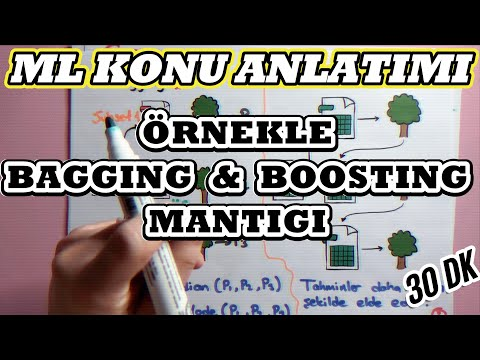

In [8]:
from IPython.display import YouTubeVideo

YouTubeVideo("PNvI8m2AM_M", 900, 600)

In [12]:
cat_features_names = [
    col for col in X_train.columns if X_train[col].dtype.kind in "bOc"
]
cat_features_names.remove("max_torque")
cat_features_names.remove("max_power")
print(cat_features_names)

['region_code', 'segment', 'model', 'fuel_type', 'engine_type', 'is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'rear_brakes_type', 'transmission_type', 'steering_type', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']


In [10]:
from IPython.display import YouTubeVideo

YouTubeVideo("2LFIeYyJOPk?si=9YwP5KNOQi5xCYoe", 900, 600)

### Optuna Tarafından Optimize Edilen Hiperparametreler

Optuna'nın en iyi kombinasyonu bulmak için deneme-yanılma yoluyla (akıllıca) aradığı ayarlardır.

*   **`depth` (Derinlik):**
    *   **Ne İşe Yarar?** CatBoost arka arkaya yüzlerce küçük Karar Ağacı (Decision Tree) oluşturur. `depth`, bu ağaçlardan her birinin ne kadar "derin" veya "karmaşık" olabileceğini belirler. Bir ağacın derinliği bir karara varmadan önce sorabileceği maksimum soru sayısı gibidir.
    *   **Etkisi:**
        
        *   **Yüksek Değer (örn: 10):** Ağaçların çok spesifik ve karmaşık kurallar öğrenmesine izin verir. Bu, eğitim verisindeki desenleri çok iyi yakalamasını sağlayabilir ancak "ezberleme" (overfitting) riskini artırır.
        
        *   **Düşük Değer (örn: 4):** Ağaçları daha basit ve genel kurallar öğrenmeye zorlar. Bu, modelin daha iyi genelleme yapmasına yardımcı olur ancak verideki karmaşık ilişkileri kaçırma (underfitting) riskini artırır.

*   **`learning_rate` (Öğrenme Oranı):**
    *   **Ne İşe Yarar?** Her yeni ağaç, bir önceki ağaçların yaptığı hataları düzeltmeye çalışır. `learning_rate`, bu düzeltme adımlarının ne kadar "büyük" olacağını kontrol eder.
    *   **Etkisi:**
        
        *   **Yüksek Değer (örn: 0.3):** Model hatalarını hızlı ve agresif bir şekilde düzeltir. Daha az ağaçla (`iterations`) sonuca ulaşabilir ama en iyi çözümü "aşma" riski vardır.
        
        *   **Düşük Değer (örn: 0.01):** Model çok küçük, temkinli adımlarla öğrenir. Genellikle daha iyi ve daha sağlam bir nihai modelle sonuçlanır, ancak bu hedefe ulaşmak için daha fazla ağaca (`iterations`) ihtiyaç duyar.

*   **`l2_leaf_reg` (L2 Regularizasyonu):**
    *   **Ne İşe Yarar?** Modeli aşırı karmaşık olmaktan veya tekil veri noktalarına aşırı güvenmekten alıkoyan bir "ceza" terimidir.
    *   **Etkisi:** Değeri ne kadar yüksek olursa, modelin fit olması o kadar zor olur.Overfitting'e karşı en etkili silahlardan biridir.

*   **`iterations` (İterasyon Sayısı):**
    *   **Ne İşe Yarar?** Modelin oluşturacağı toplam Karar Ağacı sayısıdır.
    *   **Etkisi:** `learning_rate` ile doğrudan ilişkilidir. Düşük bir öğrenme oranı, genellikle yüksek bir iterasyon sayısı gerektirir. Çok fazla iterasyon, modelin eğitim verisini ezberlemesine yol açabilir.

*   **`random_strength` (Rastgelelik Gücü):**
    *   **Ne İşe Yarar?** Ağaçların her bir dalında en iyi bölme noktasını ararken bu parametre sürece bir miktar rastgelelik katar.
    *   **Etkisi:** Modelin her zaman en bariz veya en güçlü özelliklere takılıp kalmasını önler. Onu daha az belirgin ama yine de faydalı olabilecek diğer özellikleri de keşfetmeye zorlar. Bu da overfitting'i azaltan bir başka regularizasyon tekniğidir.

---

### Sabit Olarak Ayarlanan Parametreler

*   **`loss_function="Logloss"`:** İkili sınıflandırma problemleri için standart kayıp fonksiyonudur. Modelin tahmin ettiği olasılıkların gerçek 0/1 değerlerinden ne kadar saptığını ölçer.
*   **`auto_class_weights="SqrtBalanced"`:** CatBoost'a, azınlık sınıfından (talep var) yapılan hatalara, çoğunluk sınıfından yapılan hatalardan daha fazla "ceza" vermesini söyler. "SqrtBalanced" ise aslında bu ceza ağırlıklarını hesaplamak için kullanılan özel/sofistike bir stratejidir.
*   **`cat_features=cat_features_names`:** CatBoost'un en güçlü özelliğidir diyebiliriz. Bu parametre ile CatBoost'a hangi sütunların kategorik olduğunu açıkça söyleriz. CatBoost da bu sütunları bizim için otomatik olarak kendi özel ve etkili yöntemleriyle işler.

In [ ]:
from catboost import Pool, cv

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score
from catboost import CatBoostClassifier


def objective(trial):

    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "iterations": trial.suggest_int(
            "iterations", 400, 2000
        ),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),

        "loss_function": "Logloss",
        "auto_class_weights": "SqrtBalanced",
        "random_seed": SEED,
        "eval_metric": "AUC",
        "verbose": False,
        "task_type": "GPU",
        "devices": "0",
    }

    """TunedThresholdClassifierCV ne alaka:** Optuna'nın denediği **her bir
    hiperparametre kombinasyonu için biz ayrıca o kombinasyonun **en iyi karar eşiğini**
    de buluyoruz. Bunu, daha hızlı bir iç çapraz doğrulama (`cv=3`) ile yapıyoruz. Bu,
    her denemenin adil bir şekilde, kendi potansiyelinin zirvesinde değerlendirilmesini
    sağlar. Bir hiperparametre setinin kötü bir F1 skoru almasının nedeninin sadece
    varsayılan 0.5 eşiğinin kötü olması ihtimalini ortadan kaldırırız."""
    """tuned_clf = TunedThresholdClassifierCV(
        estimator=base_clf,
        scoring='f1', # Eşiği optimize etmek için kullanılacak metrik
        cv=StratifiedKFold(n_splits=1, shuffle=True, random_state=SEED), # Daha hızlı iç CV
        random_state=SEED
    )"""

    feature_extractor = PowerTorqueRegexExtractor()
    X_transformed = feature_extractor.fit_transform(X_train)
    cat_features_transformed = [
        col for col in X_transformed.columns if col in cat_features_names
    ]

    train_pool = Pool(
        data=X_transformed, label=y_train, cat_features=cat_features_transformed
    )

    cv_results = cv(
        pool=train_pool,
        params=params,
        folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
        early_stopping_rounds=200,
        return_models=False,  # Sadece skorlara ihtiyacımız var, modellere değil
    )

    mean_recall = cv_results["test-AUC-mean"].iloc[-1]

    return mean_recall


# Optuna'nın her denemede ne yapacağını tanımlayan "kullanım kılavuzudur". Optuna,
# her yeni hiperparametre seti denemesinde bu fonksiyonu baştan sona çalıştırır ve
# fonksiyondan dönen skoru (bizim durumumuzda ortalama F1 skoru) kaydeder.
study = optuna.create_study(direction="maximize")

# 30 kere deneme yapacak.
study.optimize(objective, n_trials=10, show_progress_bar=True)

# Optuna bir döngüye girer aslında:
# Deneme 1: Bir hiperparametre seti önerir. objective fonksiyonunu bu setle çalıştırır
#           ve bir F1 skoru elde eder.
# Öğrenme: Bu parametrelerin bu skoru getirdiğini öğrenir.
# Deneme 2: İlk denemenin sonucuna göre daha "akıllı" yeni bir hiperparametre seti önerir.
#           objective fonksiyonunu tekrar çalıştırır ve yeni bir F1 skoru alır.
# Bu süreç, 10 deneme tamamlanana kadar devam eder.

print("\nEn iyi skor (CV'de Eşik Optimizasyonu ile):", study.best_value)
print("En iyi hiperparametreler:\n", study.best_params)

[I 2025-08-19 20:54:34,274] A new study created in memory with name: no-name-07f3110f-307b-4c70-bc84-02aef471499d


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.6519564092
bestIteration = 1165
Training on fold [1/5]
bestTest = 0.6549684703
bestIteration = 1170
Training on fold [2/5]
bestTest = 0.6417669654
bestIteration = 87
Training on fold [3/5]
bestTest = 0.6621857882
bestIteration = 1171
Training on fold [4/5]
bestTest = 0.6491872966
bestIteration = 740
[I 2025-08-19 20:58:40,800] Trial 0 finished with value: 0.6517624139785767 and parameters: {'depth': 6, 'learning_rate': 0.0033174029129319662, 'l2_leaf_reg': 6.522075383257998, 'iterations': 1173, 'random_strength': 1.8025674680014547}. Best is trial 0 with value: 0.6517624139785767.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.6533217728
bestIteration = 1179
Training on fold [1/5]
bestTest = 0.6573089361
bestIteration = 1173
Training on fold [2/5]
bestTest = 0.6496262252
bestIteration = 1180
Training on fold [3/5]
bestTest = 0.6621024609
bestIteration = 1143
Training on fold [4/5]
bestTest = 0.649476856
bestIteration = 695
[I 2025-08-19 21:01:43,230] Trial 1 finished with value: 0.6543034195899964 and parameters: {'depth': 4, 'learning_rate': 0.005430849443131651, 'l2_leaf_reg': 6.002854137103343, 'iterations': 1181, 'random_strength': 0.6997214275184842}. Best is trial 1 with value: 0.6543034195899964.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.6544655263
bestIteration = 339
Training on fold [1/5]
bestTest = 0.659673214
bestIteration = 484
Training on fold [2/5]
bestTest = 0.6510193646
bestIteration = 304
Training on fold [3/5]
bestTest = 0.6635119319
bestIteration = 180
Training on fold [4/5]
bestTest = 0.6472383738
bestIteration = 15
[I 2025-08-19 21:09:24,353] Trial 2 finished with value: 0.6542108297348023 and parameters: {'depth': 9, 'learning_rate': 0.0159703556676299, 'l2_leaf_reg': 9.46198952506833, 'iterations': 1828, 'random_strength': 0.360003174920581}. Best is trial 1 with value: 0.6543034195899964.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.6550376117
bestIteration = 163
Training on fold [1/5]
bestTest = 0.6587378979
bestIteration = 553
Training on fold [2/5]
bestTest = 0.6506468058
bestIteration = 367
Training on fold [3/5]
bestTest = 0.6620400846
bestIteration = 66
Training on fold [4/5]
bestTest = 0.6480395198
bestIteration = 115
[I 2025-08-19 21:13:28,388] Trial 3 finished with value: 0.6533393859863281 and parameters: {'depth': 8, 'learning_rate': 0.04599968408271627, 'l2_leaf_reg': 1.06202252753981, 'iterations': 558, 'random_strength': 1.5661084226227098}. Best is trial 1 with value: 0.6543034195899964.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.6532913446
bestIteration = 128
Training on fold [1/5]
bestTest = 0.6591388583
bestIteration = 413
Training on fold [2/5]
bestTest = 0.6519475877
bestIteration = 728
Training on fold [3/5]
bestTest = 0.6617056131
bestIteration = 99
Training on fold [4/5]
bestTest = 0.6488720775
bestIteration = 61
[I 2025-08-19 21:15:40,177] Trial 4 finished with value: 0.6543709456920623 and parameters: {'depth': 6, 'learning_rate': 0.029364728391693795, 'l2_leaf_reg': 9.00533910558688, 'iterations': 1700, 'random_strength': 1.3208892933790786}. Best is trial 4 with value: 0.6543709456920623.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.6532754898
bestIteration = 607
Training on fold [1/5]
bestTest = 0.6592081785
bestIteration = 1240
Training on fold [2/5]
bestTest = 0.6519860327
bestIteration = 1339
Training on fold [3/5]
bestTest = 0.6629832089
bestIteration = 483
Training on fold [4/5]
bestTest = 0.6484127939
bestIteration = 170
[I 2025-08-19 21:25:03,856] Trial 5 finished with value: 0.6545894265174865 and parameters: {'depth': 8, 'learning_rate': 0.016907043732341483, 'l2_leaf_reg': 6.281519157871911, 'iterations': 1340, 'random_strength': 1.5019722755886558}. Best is trial 5 with value: 0.6545894265174865.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.6542855799
bestIteration = 54
Training on fold [1/5]
bestTest = 0.6529118717
bestIteration = 79
Training on fold [2/5]
bestTest = 0.6513781548
bestIteration = 225
Training on fold [3/5]
bestTest = 0.6599690914
bestIteration = 14
Training on fold [4/5]
bestTest = 0.6461704969
bestIteration = 39
[I 2025-08-19 21:28:04,270] Trial 6 finished with value: 0.6469771325588226 and parameters: {'depth': 8, 'learning_rate': 0.20727077258516652, 'l2_leaf_reg': 2.1095216212739194, 'iterations': 1359, 'random_strength': 1.313293474770503}. Best is trial 5 with value: 0.6545894265174865.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.6529993117
bestIteration = 380
Training on fold [1/5]
bestTest = 0.658593446
bestIteration = 623
Training on fold [2/5]
bestTest = 0.6532184184
bestIteration = 667
Training on fold [3/5]
bestTest = 0.662515521
bestIteration = 318
Training on fold [4/5]
bestTest = 0.6498663723
bestIteration = 59
[I 2025-08-19 21:31:34,151] Trial 7 finished with value: 0.6546359956264496 and parameters: {'depth': 7, 'learning_rate': 0.023914418748212214, 'l2_leaf_reg': 6.228696122565741, 'iterations': 668, 'random_strength': 1.2922415177758793}. Best is trial 7 with value: 0.6546359956264496.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.6490550637
bestIteration = 114
Training on fold [1/5]
bestTest = 0.6532990336
bestIteration = 51
Training on fold [2/5]
bestTest = 0.6473804414
bestIteration = 60
Training on fold [3/5]
bestTest = 0.6575102806
bestIteration = 455
Training on fold [4/5]
bestTest = 0.6463529468
bestIteration = 14
[I 2025-08-19 21:32:34,178] Trial 8 finished with value: 0.6501053392887115 and parameters: {'depth': 5, 'learning_rate': 0.0011532692994310034, 'l2_leaf_reg': 6.58068994509282, 'iterations': 462, 'random_strength': 0.48375089132212246}. Best is trial 7 with value: 0.6546359956264496.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:877: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(
Default metric period is 5 because AUC is/are not implemented for GPU


Training on fold [0/5]
bestTest = 0.6512966752
bestIteration = 1189
Training on fold [1/5]
bestTest = 0.6527425349
bestIteration = 81
Training on fold [2/5]
bestTest = 0.6457541287
bestIteration = 135
Training on fold [3/5]
bestTest = 0.6607029736
bestIteration = 1195
Training on fold [4/5]
bestTest = 0.6472406685
bestIteration = 13
[I 2025-08-19 21:35:16,337] Trial 9 finished with value: 0.6509912371635437 and parameters: {'depth': 6, 'learning_rate': 0.0020422124080322693, 'l2_leaf_reg': 6.986126631477772, 'iterations': 1196, 'random_strength': 0.6697479893592566}. Best is trial 7 with value: 0.6546359956264496.

En iyi skor (CV'de Eşik Optimizasyonu ile): 0.6546359956264496
En iyi hiperparametreler:
 {'depth': 7, 'learning_rate': 0.023914418748212214, 'l2_leaf_reg': 6.228696122565741, 'iterations': 668, 'random_strength': 1.2922415177758793}


In [22]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [25]:
best_base_cat = CatBoostClassifier(
    loss_function="Logloss",
    auto_class_weights="SqrtBalanced",
    random_seed=SEED,
    verbose=False,
    thread_count=-1,
    task_type="GPU",
    cat_features=cat_features_names,
    early_stopping_rounds=200,
    **study.best_params,  # Optuna'nın bulduğu en iyi parametreler
)

# 2. YENİ ADIM: En iyi temel modeli, son kez eğitmek üzere TEKRAR sarmala
#    Bu .fit() çağrıldığında, en iyi eşiği bulup saklayacak.
final_tuned_cat_model = TunedThresholdClassifierCV(
    estimator=best_base_cat,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    random_state=SEED,
)

# 3. Final pipeline'ı bu son sarmalanmış modelle kur
cat_pipe = Pipeline(
    steps=[("fe", PowerTorqueRegexExtractor()), ("clf", final_tuned_cat_model)]
)

# 4. Pipeline'ı TÜM eğitim verisiyle eğit
#    .fit() çağrısı, final_tuned_cat_model'in en iyi eşiği bulmasını ve saklamasını tetikler.
cat_pipe.fit(X_train, y_train)

# Eğitilmiş pipeline'dan en iyi eşiği alıp yazdıralım
best_threshold_found = cat_pipe.named_steps["clf"].best_threshold_
print(f"\nTüm eğitim verisi üzerinde bulunan en iyi eşik: {best_threshold_found:.4f}")


Tüm eğitim verisi üzerinde bulunan en iyi eşik: 0.3166


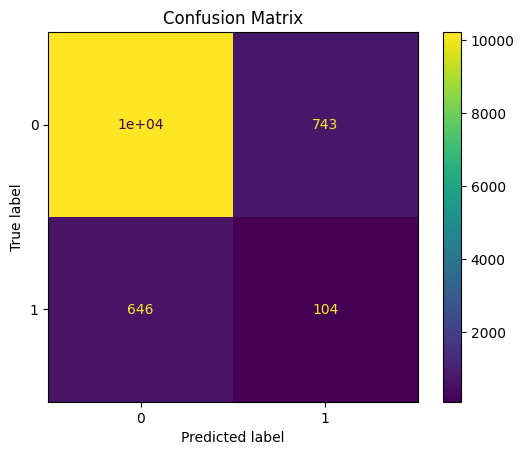

In [27]:
ConfusionMatrixDisplay.from_estimator(cat_pipe, X_test, y_test)
plt.title(f"Confusion Matrix")
plt.grid(False)
plt.show()

In [26]:
y_pred_hpo = cat_pipe.predict(X_test)

print(
    "\nHPO ve Eşik Optimizasyonu sonrası CatBoost — Test F1 (macro):",
    f1_score(y_test, y_pred_hpo, average="macro"),
)
y_proba_hpo = cat_pipe.predict_proba(X_test)[:, 1]
print("ROC-AUC (HPO-CatBoost):", roc_auc_score(y_test, y_proba_hpo))


HPO ve Eşik Optimizasyonu sonrası CatBoost — Test F1 (macro): 0.5333241093475797
ROC-AUC (HPO-CatBoost): 0.6636853556993952


## Durum Değerlendirmesi - Neler Oluyor?

Bu sonuçlar ilk bakışta beklentilerin tersi gibi görünebilir.

Gelişmiş, hiperparametre optimizasyonu yapılmış CatBoost modelimiz, daha basit olan Decision Tree modeline göre asıl hedefimiz olan **"gerçek talepleri (Class 1) yakalama"** konusunda daha zayıf kalmış görünüyor.

Bunların bize ne anlattığını derinlemesine inceleyelim.

---

### CatBoost Modelinin Karnesi (İlk Matris - 104 TP)

*   **Doğru Pozitif (True Positive - 104):** Modelimiz gerçekte "talep var" (1) olan **104** vakayı doğru tahmin etmiş.
*   **Yanlış Negatif (False Negative - 646):** **Bu en kritik nokta.** Model gerçekte "talep var" (1) olan tam **646** vakayı gözden kaçırmış ve "talep yok" (0) demiş. **Modelin en büyük zayıflığı.**
*   **Yanlış Pozitif (False Positive - 743):** Model, "talep yok" (0) olan **743** vakaya yanlışlıkla "talep var" (1) demiş. Yani yanlış alarm sayısı oldukça düşük.
*   **Doğru Negatif (True Negative - ~10,000):** Model, "talep yok" (0) olan vakaları tespit etmede ezici bir çoğunlukla başarılı.

---

### Decision Tree Modelinin Karnesi (İkinci Matris - 177 TP)

*   **Doğru Pozitif (True Positive - 177):** Bu model **177** gerçek talebi başarıyla yakalamış.
*   **Yanlış Negatif (False Negative - 573):** **573** gerçek talebi gözden kaçırmış. Bu sayı hala yüksek olsa da, CatBoost'tan belirgin şekilde daha iyi.
*   **Yanlış Pozitif (False Positive - 1600):** Modelin zayıf yeri burası. Gerçek talepleri bulmak için daha "cesur" davrandığı için, tam **1600** kez yanlış alarm vermiş.
*   **Doğru Negatif (True Negative - 9369):** "Talep yok" vakalarını tespit etme başarısı hala yüksek.

**Decision Tree'nin Karakteri:** Bu model daha **"agresif"** ve **"proaktif"**. "Birkaç yanlış alarm vermeyi göze alırım ama ana görevim olan gerçek talepleri kaçırmamalıyım" stratejisini izliyor.

---

### Nihai Karşılaştırma ve Şaşırtıcı Sonuç

| Metrik | CatBoost (Optimize Edilmiş) | Decision Tree (Temel) | Kazanan |
| :--- | :--- | :--- | :--- |
| **Yakalanan Gerçek Talep (TP)** | 104 | **177** | **Decision Tree** |
| **Kaçırılan Gerçek Talep (FN)** | 646 | **573** | **Decision Tree** |
| **Yanlış Alarm Sayısı (FP)** | **743** | 1600 | **CatBoost** |

**Yorum:**
Daha basit olan Decision Tree modeli, işimizin en kritik hedefi olan **gerçek talepleri bulma ve kaçırmama** konusunda, üzerinde bu kadar çalıştığımız CatBoost modelinden **daha iyi bir performans sergilemiş.**

**Peki Neden Böyle Oldu? Bu Bir Başarısızlık mı?**

Yoo. Bu aslında ML sürecinin en öğretici anlarından biridir.

1.  **Aşırı Optimizasyon?:** Bazen hiperparametre optimizasyonu, modeli eğitim setindeki belirli bir dengeye o kadar iyi oturtur ki, test setindeki farklı bir dağılıma genelleme yapmakta zorlanır. CatBoost, "yanlış alarm vermemenin" eğitim setinde daha ödüllendirici bir strateji olduğuna karar vermiş olabilir.


**Sonuç:** Bu karşılaştırma bize şunu gösteriyor: **En karmaşık model veya en uzun optimizasyon süreci her zaman en iyi sonucu vermez.** Modelin başarısı, tamamen probleme uygun metriklerle değerlendirilmesine ve optimize edilmesine bağlıdır.

In [31]:
from sklearn.metrics import recall_score, classification_report

In [33]:
recall_per_threshold = {}
for thresh in np.linspace(0.05, 0.35, num=25):
    y_pred_thresh = cat_pipe.predict_proba(X_test)[:, 1] > thresh
    recall_per_threshold[thresh] = recall_score(y_test, y_pred_thresh)

    print(f"Eşik: {thresh:.3f} | Recall: {recall_per_threshold[thresh]:.3f}")

Eşik: 0.050 | Recall: 1.000
Eşik: 0.062 | Recall: 0.996
Eşik: 0.075 | Recall: 0.989
Eşik: 0.087 | Recall: 0.972
Eşik: 0.100 | Recall: 0.955
Eşik: 0.112 | Recall: 0.932
Eşik: 0.125 | Recall: 0.919
Eşik: 0.138 | Recall: 0.896
Eşik: 0.150 | Recall: 0.865
Eşik: 0.162 | Recall: 0.837
Eşik: 0.175 | Recall: 0.813
Eşik: 0.188 | Recall: 0.775
Eşik: 0.200 | Recall: 0.729
Eşik: 0.212 | Recall: 0.675
Eşik: 0.225 | Recall: 0.623
Eşik: 0.237 | Recall: 0.557
Eşik: 0.250 | Recall: 0.501
Eşik: 0.263 | Recall: 0.444
Eşik: 0.275 | Recall: 0.376
Eşik: 0.287 | Recall: 0.280
Eşik: 0.300 | Recall: 0.207
Eşik: 0.312 | Recall: 0.153
Eşik: 0.325 | Recall: 0.109
Eşik: 0.337 | Recall: 0.092
Eşik: 0.350 | Recall: 0.085


### Hangi Eşiği Seçmeliyiz? (İş Problemine Göre Karar Verme)

İşte projemizin en stratejik kısmı burasıdır. Doğru eşik, tamamen işin hedeflerine ve kaynaklarına bağlıdır.

**Senaryo 1: "Hiçbir Şüpheli Vaka Gözden Kaçmasın!"**
*   **Hedef:** Finansal kayıp riski çok yüksek. Bir sahtekarlığı veya geçerli talebi kaçırmanın maliyeti, birkaç yanlış alarmı incelemekten çok daha fazla. Analist ekibimiz bu incelemeyi yapabilir.
*   **Seçilecek Eşik:** **Düşük bir eşik.** Örneğin, **0.150** eşiğini seçerek gerçek taleplerin **%86.5'ini** yakalayabiliriz.

**Senaryo 2: "Analistleri Boğmadan Makul Bir Başarı Elde Edelim"**
*   **Hedef:** Hem talepleri yakalamak hem de analistlerin iş yükünü yönetmek istiyoruz. Dengeli bir yaklaşım lazım.
*   **Seçilecek Eşik:** **Orta bir eşik.** Örneğin, **0.250** eşiğini seçerek taleplerin yarısını (**%50.1 Recall**) yakalayabiliriz. Bu bir önceki duruma göre hala devasa bir iyileşmedir ve yanlış alarm sayısı Senaryo 1'e göre daha yönetilebilir olacaktır.

**Senaryo 3: "Sadece Neredeyse Kesin Olan Vakaları Göster"**
*   **Hedef:** Analist kaynağımız çok kısıtlı. Sadece "banko" vakalarla ilgilenebiliriz.
*   **Seçilecek Eşik:** **Yüksek bir eşik.** Örneğin, **0.300** eşiğini seçerek taleplerin **%20.7'sini** yakalarız. Decision Tree'nin Recall'una (%23.6) yakın bir değerdir.

In [35]:
for thresh in np.linspace(0.05, 0.35, num=25):
    y_pred_thresh = cat_pipe.predict_proba(X_test)[:, 1] > thresh
    print(f"Eşik: {thresh:.3f}")
    print(classification_report(y_test, y_pred_thresh, digits=4))
    print("-" * 50)

Eşik: 0.050
              precision    recall  f1-score   support

           0     1.0000    0.0015    0.0031     10969
           1     0.0641    1.0000    0.1205       750

    accuracy                         0.0654     11719
   macro avg     0.5320    0.5008    0.0618     11719
weighted avg     0.9401    0.0654    0.0106     11719

--------------------------------------------------
Eşik: 0.062
              precision    recall  f1-score   support

           0     0.9706    0.0090    0.0179     10969
           1     0.0643    0.9960    0.1208       750

    accuracy                         0.0722     11719
   macro avg     0.5174    0.5025    0.0693     11719
weighted avg     0.9126    0.0722    0.0245     11719

--------------------------------------------------
Eşik: 0.075
              precision    recall  f1-score   support

           0     0.9857    0.0503    0.0958     10969
           1     0.0665    0.9893    0.1246       750

    accuracy                         0.1104 

In [18]:
def objective_dt(trial):

    params = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 3, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 40),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 40),
        "max_features": trial.suggest_categorical(
            "max_features", ["sqrt", "log2", None]
        ),
        "random_state": SEED,
    }

    base_dt = DecisionTreeClassifier(**params)

    tuned_dt = TunedThresholdClassifierCV(
        estimator=base_dt,
        scoring="f1",
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),  # İç CV
        random_state=SEED,
    )

    pipeline = Pipeline(steps=[("data_prep", data_prep_pipeline), ("clf", tuned_dt)])

    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    score = cross_val_score(
        pipeline, X_train, y_train, cv=outer_cv, scoring="f1", n_jobs=-1
    )

    return score.mean()


study_dt = optuna.create_study(direction="maximize")

study_dt.optimize(objective_dt, n_trials=50, show_progress_bar=True)


# --- 3. Sonuçları Yazdırma ---

print("\n--- Decision Tree Optimizasyon Sonuçları ---")
print("En iyi F1 skoru (CV Ortalaması):", study_dt.best_value)
print("En iyi hiperparametreler:\n", study_dt.best_params)

[I 2025-08-20 15:08:24,475] A new study created in memory with name: no-name-85a550a5-aa82-4a0d-a19d-057753ba0a75


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-08-20 15:08:39,961] Trial 0 finished with value: 0.14873577666672927 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 21, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.14873577666672927.
[I 2025-08-20 15:08:49,458] Trial 1 finished with value: 0.14309037621300297 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 17, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.14873577666672927.
[I 2025-08-20 15:08:59,041] Trial 2 finished with value: 0.15064509184613809 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 23, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.15064509184613809.
[I 2025-08-20 15:09:08,494] Trial 3 finished with value: 0.1342760392210102 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 37, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 2 with value

In [20]:
best_dt = DecisionTreeClassifier(**study_dt.best_params, random_state=SEED)
dt_pipe = Pipeline(steps=[("data_prep", data_prep_pipeline), ("clf", best_dt)])
dt_pipe.fit(X_train, y_train)

y_pred_dt = dt_pipe.predict(X_test)
y_pred_proba_dt = dt_pipe.predict_proba(X_test)[:, 1]

In [22]:
for thresh in np.linspace(0.05, 0.35, num=25):
    y_pred_thresh = dt_pipe.predict_proba(X_test)[:, 1] > thresh
    print(f"Eşik: {thresh:.3f}")
    print(classification_report(y_test, y_pred_thresh, digits=4))
    print("-" * 50)

Eşik: 0.050
              precision    recall  f1-score   support

           0     0.9676    0.4490    0.6134     10969
           1     0.0882    0.7800    0.1586       750

    accuracy                         0.4702     11719
   macro avg     0.5279    0.6145    0.3860     11719
weighted avg     0.9113    0.4702    0.5843     11719

--------------------------------------------------
Eşik: 0.062
              precision    recall  f1-score   support

           0     0.9675    0.4586    0.6222     10969
           1     0.0891    0.7747    0.1598       750

    accuracy                         0.4788     11719
   macro avg     0.5283    0.6166    0.3910     11719
weighted avg     0.9113    0.4788    0.5926     11719

--------------------------------------------------
Eşik: 0.075
              precision    recall  f1-score   support

           0     0.9563    0.6323    0.7613     10969
           1     0.0970    0.5773    0.1660       750

    accuracy                         0.6288 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Eşik: 0.312
              precision    recall  f1-score   support

           0     0.9360    1.0000    0.9669     10969
           1     0.0000    0.0000    0.0000       750

    accuracy                         0.9360     11719
   macro avg     0.4680    0.5000    0.4835     11719
weighted avg     0.8761    0.9360    0.9051     11719

--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Eşik: 0.325
              precision    recall  f1-score   support

           0     0.9360    1.0000    0.9669     10969
           1     0.0000    0.0000    0.0000       750

    accuracy                         0.9360     11719
   macro avg     0.4680    0.5000    0.4835     11719
weighted avg     0.8761    0.9360    0.9051     11719

--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Eşik: 0.337
              precision    recall  f1-score   support

           0     0.9360    1.0000    0.9669     10969
           1     0.0000    0.0000    0.0000       750

    accuracy                         0.9360     11719
   macro avg     0.4680    0.5000    0.4835     11719
weighted avg     0.8761    0.9360    0.9051     11719

--------------------------------------------------
Eşik: 0.350
              precision    recall  f1-score   support

           0     0.9360    1.0000    0.9669     10969
           1     0.0000    0.0000    0.0000       750

    accuracy                         0.9360     11719
   macro avg     0.4680    0.5000    0.4835     11719
weighted avg     0.8761    0.9360    0.9051     11719

--------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

### Optimize Edilmiş Decision Tree vs. Optimize Edilmiş CatBoost

Şimdi asıl soru şu: Bu zirve noktalarında hangisi daha iyi performans gösteriyor ve hangisi iş hedeflerimiz için daha kullanışlı?

#### Raund 1: Modelin Karakteri ve Davranışı

**Decision Tree (DT) - "Kırılgan Savaşçı":**
DT'nin raporlarına baktığımızda çok çarpıcı bir tablo görüyoruz. Modelin çok dar bir "etkili" çalışma aralığı var.
*   **Düşük Eşiklerde (0.050 - 0.087):** Model oldukça "agresif". Gerçek taleplerin **%57 ila %78'ini** yakalayabiliyor. Bu harika bir başlangıç.
*   **Ani Çöküş (Eşik > 0.162):** Model aniden "pes ediyor". Eşik 0.162'yi geçtiği anda, Class 1 için Recall skoru neredeyse sıfıra (%0.13) düşüyor. Eşik 0.300'e geldiğinde ise model **hiçbir şekilde talep tahmini yapmıyor** (`recall=0.0000`). Modelin olasılık çıktılarının çok dar bir aralıkta yığıldığını ve bu eşiğin üzerinde hiçbir örnek bulamadığını gösterir. Bu durum deployment ortamı için oldukça risklidir. Modelin durduk yere kırılmasını istemeyiz:).

**CatBoost:**
CatBoost'un davranış profili ise tamamen farklı.
*   **Pürüzsüz Geçiş:** Eşik değeri arttıkça Recall skoru tahmin edilebilir ve pürüzsüz bir şekilde azalırken, Precision yavaş yavaş artıyor.
*   **Geniş Çalışma Aralığı:** Neredeyse her iş ihtiyacına uygun bir çalışma noktası sunuyor. İsterseniz %100 Recall ile (çok fazla yanlış alarmla) çalışabilir, isterseniz %10 Recall ile (çok az yanlış alarmla) çalışabilirsiniz. Bu esneklik, iş birimlerinin değişen ihtiyaçlarına uyum sağlama yeteneği demektir.

**İlk Raundun Galibi:** **CatBoost**. Modelin öngörülebilir ve esnek davranışı, onu daha güvenilir ve kullanışlı kılıyor.

---

#### Raund 2: Zirve Performanslarının Karşılaştırılması (F1-Skoru)

Her modelin en dengeli olduğu, yani F1-skorunun zirve yaptığı noktayı karşılaştıralım.

*   **Decision Tree'nin En İyi Anı:**
    *   **Eşik: 0.075**
    *   **F1-Skoru (Class 1): 0.1660**
    *   Bu noktada taleplerin **%57.7'sini** yakalıyor ve tahminlerinin **%9.7'si** doğru çıkıyor.

*   **CatBoost'un En İyi Anı:**
    *   **Eşik: 0.263**
    *   **F1-Skoru (Class 1): 0.1794**
    *   Bu noktada taleplerin **%44.4'ünü** yakalıyor ve tahminlerinin **%11.2'si** doğru çıkıyor.

**İkinci Raundun Galibi:** **CatBoost**. En dengeli noktasında, hem daha yüksek bir F1-skoruna sahip hem de daha isabetli (daha yüksek Precision) tahminler yapıyor.

---

### Final Tablosu: Stratejik Karşılaştırma

Şimdi en kritik senaryolar için modelleri kafa kafaya karşılaştıralım.

| Strateji | Decision Tree (Optimize) | CatBoost (Optimize) | **Kazanan** |
| :--- | :--- | :--- | :--- |
| **Model Karakteri** | Kırılgan, dar çalışma aralığı, ani çöküş riski | Esnek, geniş çalışma aralığı, pürüzsüz geçişler | **CatBoost** |
| | | | |
| **En Dengeli Performans (En Yüksek F1)**| **Eşik: 0.075**<br>F1: 16.6%<br>Recall: 57.7%<br>Precision: 9.7% | **Eşik: 0.263**<br>**F1: 17.9%**<br>Recall: 44.4%<br>Precision: 11.2% | **CatBoost** |
| | | | |
| **Yüksek Yakalama Oranı Senaryosu**<br>(Recall ≈ %77 hedefi) | **Eşik: 0.062**<br>Recall: 77.5%<br>Precision: 8.9% | **Eşik: 0.188**<br>Recall: 77.5%<br>**Precision: 9.1%** | **CatBoost** |

### Nihai Karar - CatBoost

Sebepleri şunlardır:

1.  **Üstün Performans:** Her türlü adil karşılaştırmada (en iyi F1 skoru, eşdeğer Recall seviyeleri) CatBoost, Decision Tree'den marjinal de olsa daha iyi metrikler sunmaktadır.
2.  **Esneklik ve Kontrol:** Bu en önemli farktır. CatBoost, iş ihtiyaçlarına göre hassas bir şekilde ayarlanabilir. DT ise kısıtlı seçenekler sunan ve beklenmedik şekilde "kırılabilen" bir modeldir.
3.  **Güvenilirlik:** CatBoost'un pürüzsüz ve öngörülebilir davranışı, onu bir üretim ortamında (production) kullanmak için çok daha güvenilir bir aday yapar. Decision Tree'nin ani çöküşü, gerçek dünyada kabul edilemez bir risktir.

### Sonuç ve Aksiyon Planı

1.  **Başarı:** Her modelin artı ve eksileri var.
2.  **Kontrol Bizde:** Artık modelin karakterini siz belirleyebilirsiniz.

## Kaydetme

In [ ]:
joblib.dump(dt_pipe, "best_model_pipeline.pkl")
print("Kaydedildi: best_model_pipeline.pkl")

sample = X_test.iloc[[0]].copy()
print("Örnek satır:\n", sample)
print("\nTahmin:", best_pipe.predict(sample)[0])
if hasattr(best_pipe.named_steps["clf"], "predict_proba"):
    print("Sınıf 1 olasılığı:", float(best_pipe.predict_proba(sample)[:, 1]))